In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
# --------------------- #
# Step 1: Load the data #
# --------------------- #
df = pd.read_excel("Master_ML_FourthPass.xlsx")

In [48]:
# --------------------------------------------------------------------- #
# Step 1.1: Remove referees that have a count less than a certain value #
# --------------------------------------------------------------------- #
counts = df['Referee'].value_counts()
rare_refs = counts[counts < 100].index
df = df[~df['Referee'].isin(rare_refs)]

# ----------------------------------- #
# Step 2: Define targets and features #
# ----------------------------------- #

# --------------------------------------------------- #
# Determines the approach; faster then rewriting code #
# --------------------------------------------------- #
# Target = 'Referee'
Target = 'WIN'
Feature = 'Referee' if Target == 'WIN' else 'WIN'

# APPROACH 1: Determining if the model can guess who refereed the game.
# APPROACH 2: Determining if the model can guess who won/lost/drew 
y = df[Target]
x = df.drop(Target, axis=1)

In [49]:
# ------------------------------- #
# Step 3: Label encode the target #
# ------------------------------- #
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [51]:
# ---------------------------------------------- #
# Step 4: One hot encode key categorical columns #
# ---------------------------------------------- #
categorial_columns = ["Home", "Away", "HomeCity", "RefereeBirthCity_ByRegion", Feature]
x_encoded = pd.get_dummies(x, columns=categorial_columns, drop_first=True)

In [52]:
# ----------------------------- #
# Step 5: Handle missing values #
# ----------------------------- #
imputer = SimpleImputer(strategy='mean')
x_imputed = pd.DataFrame(imputer.fit_transform(x_encoded), columns=x_encoded.columns)
# this is a weak way of imputing. Unless we do k-nearest neighbors. 
# do the k-nearest neighbors AFTER scaling [step 6].

In [53]:
# ----------------------------- #
# Step 6: Scale numeric columns #
# ----------------------------- #
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_imputed)

In [54]:
# K NEAREST NEIGHBORS GOES HERE - FOR THE EMPTY STATS [1500 rows]


In [55]:
# ------------------------ #
# Step 7: Split train/test #
# ------------------------ #
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [56]:
# --------------------------- #
# Step 8: Train Random Forest #
# --------------------------- #
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [57]:
# ----------------------------- #
# Step 9 - Evaluate Performance #
# ----------------------------- #
y_pred = rf.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy:  0.5133004926108374
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.52      0.51       313
           1       0.25      0.07      0.11       244
           2       0.56      0.74      0.64       458

    accuracy                           0.51      1015
   macro avg       0.43      0.45      0.42      1015
weighted avg       0.46      0.51      0.47      1015



In [58]:
# --------------------------------------------- #
# Step 10 - Feature Importance (Detection Bias) #
# --------------------------------------------- #
importances = rf.feature_importances_
features = x_encoded.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print("\nTop 30 Most Influential Features:")
print(importance_df.head(30))


Top 15 Most Influential Features:
                             Feature  Importance
6                  H_Ball_Possession    0.046157
7                  A_Ball_Possession    0.046143
15                    A_Yellow_Cards    0.040922
8                       H_Free_Kicks    0.040436
14                    H_Yellow_Cards    0.040036
9                       A_Free_Kicks    0.039757
13                           A_Fouls    0.039115
12                           H_Fouls    0.038917
10                    H_Corner_Kicks    0.038683
11                    A_Corner_Kicks    0.037004
5                               UEFA    0.035702
1                                CAF    0.020327
2                           CONMEBOL    0.019788
3                           CONCACAF    0.012398
132  RefereeBirthCity_ByRegion_North    0.011865
16                       H_Red_Cards    0.011141
116              HomeCity_Manchester    0.011007
114                  HomeCity_London    0.010720
80              Away_Manchester Ci


Federation Feature Importance
    Feature  Importance
5      UEFA    0.035702
1       CAF    0.020327
2  CONMEBOL    0.019788
3  CONCACAF    0.012398
0       AFC    0.005196
4       OFC    0.001864

Grouped Feature Importances:
Feature
Federation          0.095275
MatchStats          0.886182
RefereeBirthCity    0.018543
Name: Importance, dtype: float64


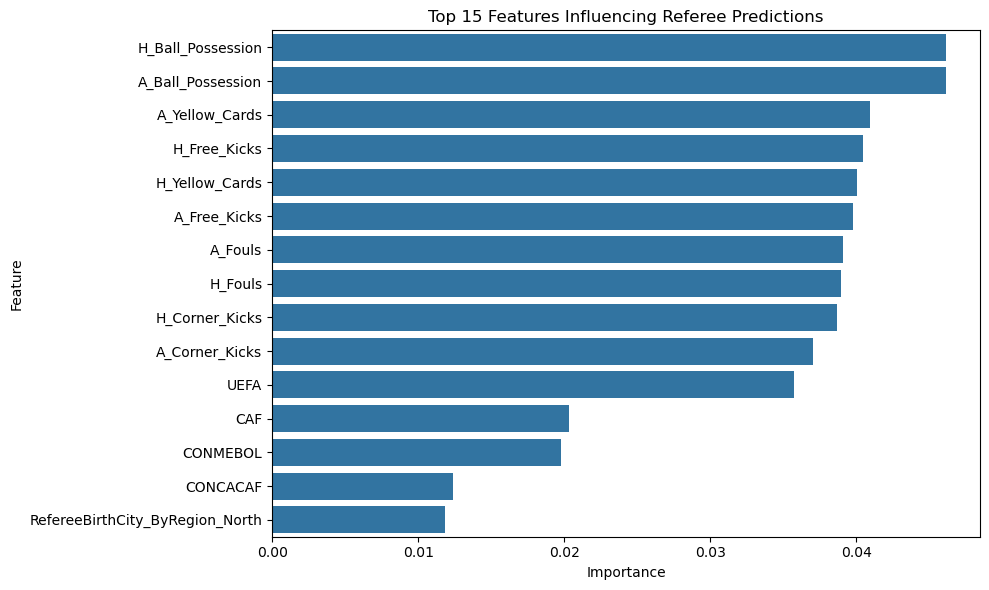

In [62]:
# ----------------------- #
# Step 11 - Visualize it! #
# ----------------------- #
federation_importance = importance_df[importance_df['Feature'].str.contains("AFC|CAF|UEFA|CONMEBOL|CONCACAF|OFC")]
print("\nFederation Feature Importance")
print(federation_importance)

grouped_importance = importance_df.groupby(
    importance_df['Feature'].apply(
        lambda x: 'Federation' if any(f in x for f in ["AFC", "CAF", "UEFA", "CONMEBOL", "CONCACAF", "OFC"])
        else 'RefereeBirthCity' if 'RefereeBirthCity_ByRegion' in x
        else 'MatchStats'
    )
)['Importance'].sum()
print("\nGrouped Feature Importances:")
print(grouped_importance)


plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
plt.title('Top 15 Features Influencing Referee Predictions')
plt.tight_layout()
plt.show()

In [34]:
# -------------------------- #
# Step 12 - Multiple Models! #
# -------------------------- #
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000), # Add regularization to the parameters
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=20) # Adjust, make this smaller depending
}

results = []

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": acc})
    print(f"\n{name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred, zero_division=0))

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\nModel Comparison:")
print(results_df)


Logistic Regression
Accuracy: 0.529064039408867
              precision    recall  f1-score   support

           0       0.52      0.56      0.54       313
           1       0.26      0.08      0.12       244
           2       0.56      0.75      0.64       458

    accuracy                           0.53      1015
   macro avg       0.45      0.46      0.43      1015
weighted avg       0.48      0.53      0.49      1015


Decision Tree
Accuracy: 0.4206896551724138
              precision    recall  f1-score   support

           0       0.41      0.43      0.42       313
           1       0.27      0.27      0.27       244
           2       0.52      0.49      0.51       458

    accuracy                           0.42      1015
   macro avg       0.40      0.40      0.40      1015
weighted avg       0.43      0.42      0.42      1015


Random Forest
Accuracy: 0.5133004926108374
              precision    recall  f1-score   support

           0       0.49      0.52      0.51   

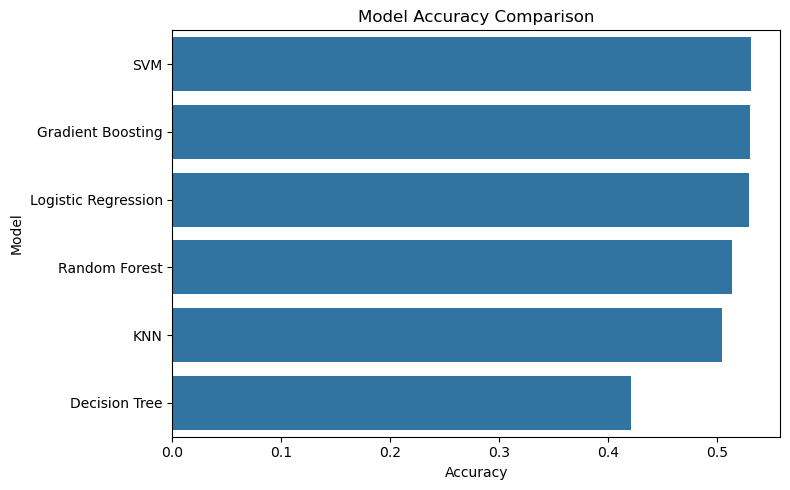

In [35]:
# -------------------------- #
# Visualize multiple models! #
# -------------------------- #

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Accuracy", y="Model")
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()